In [1]:
from fastai.vision.all import *
from moving_mnist.models.seq2seq import *
from moving_mnist.models.conv_rnn import StackUnstack, StackLoss, MultiImageDice
from moving_mnist.data import *

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print(torch.cuda.get_device_name())

Quadro RTX 8000


# Train Example:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [3]:
Path.cwd()

Path('/home/tcapelle/SteadySun/moving_mnist')

In [4]:
DATA_PATH = Path.cwd()/'data'

In [5]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=[1,2], th=0.7)

In [6]:
train_tl = TfmdLists(range(7500), ImageTupleTransform(ds, cl_type=TensorMask))
valid_tl = TfmdLists(range(100), ImageTupleTransform(ds, cl_type=TensorMask))

In [7]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=64,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

In [8]:
loss_func = StackLoss(CrossEntropyLossFlat(axis=1))
metrics = [MultiImageDice(axis=1)]

Left: Input, Right: Target

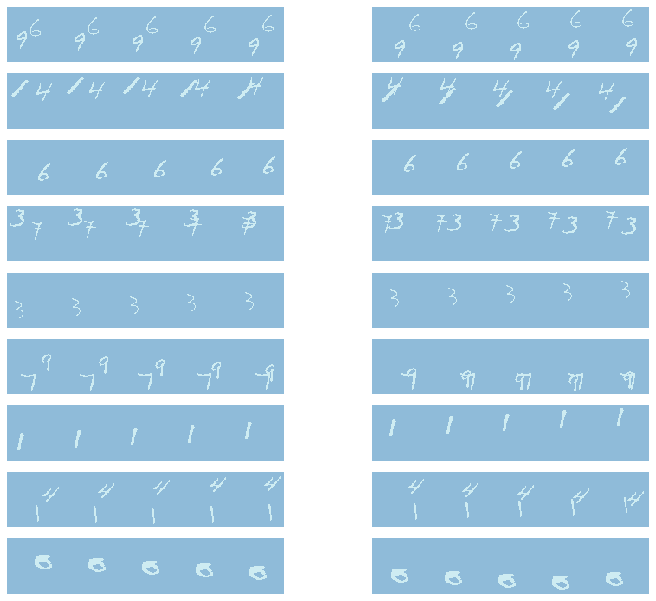

In [9]:
dls.show_batch()

## Baseline

`StackUnstack` takes cares of stacking the list of images into a fat tensor, and unstacking them at the end, we will need to modify our loss function to take a list of tensors as input and target.

In [10]:
model = StackUnstack(SimpleModel(5, ch_out=2), dim=1).cuda()

As the `ImageSeq` is a `tuple` of images, we will need to stack them to compute loss.

In [11]:
# x,y = dls.one_batch()

# out = model(x)

# len(out)

# out[0].shape, y[0].shape

# loss_func(model(x), y)

In [12]:
learn = Learner(dls, model, loss_func=loss_func, metrics=metrics, cbs=[]).to_fp16()

I have a weird bug that if I use `nn.LeakyReLU` after doing `learn.lr_find()` the model does not train (the loss get stucked).

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=0.0003311311302240938)

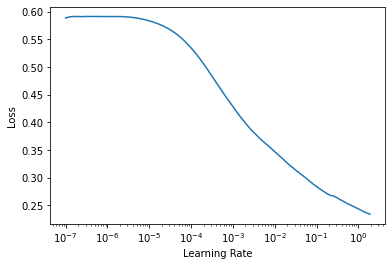

In [13]:
learn.lr_find()

In [14]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,multi_image_dice,time
0,0.141491,0.098517,0.005361,00:15
1,0.090384,0.088456,0.079626,00:15
2,0.080365,0.076990,0.251540,00:16
3,0.075283,0.070318,0.242326,00:16
4,0.072267,0.070187,0.305111,00:16
5,0.070152,0.067329,0.286970,00:16
6,0.067653,0.060650,0.360817,00:16
7,0.065746,0.059496,0.322269,00:16
8,0.065793,0.067782,0.357465,00:16
9,0.065635,0.058821,0.374350,00:16


In [15]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [16]:
len(p), p[0].shape

(5, torch.Size([100, 2, 64, 64]))

In [17]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

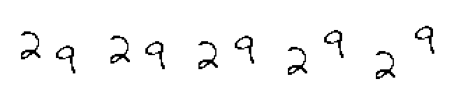

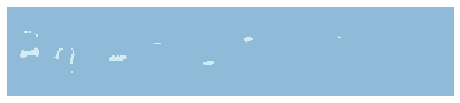

In [18]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k, True)